In [1]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset_name = "vqa-rad"

In [3]:

if dataset_name == 'path-vqa':
    dataset = load_dataset("flaviagiammarino/path-vqa")
else:
    dataset = {
        'train': load_dataset("flaviagiammarino/vqa-rad", split="train"),
        'validation':load_dataset("flaviagiammarino/vqa-rad", split="test")
    }


In [4]:
dataset

{'train': Dataset({
     features: ['image', 'question', 'answer'],
     num_rows: 1793
 }),
 'validation': Dataset({
     features: ['image', 'question', 'answer'],
     num_rows: 451
 })}

Question: is it possible to identify the right renal vein?
Answer: no


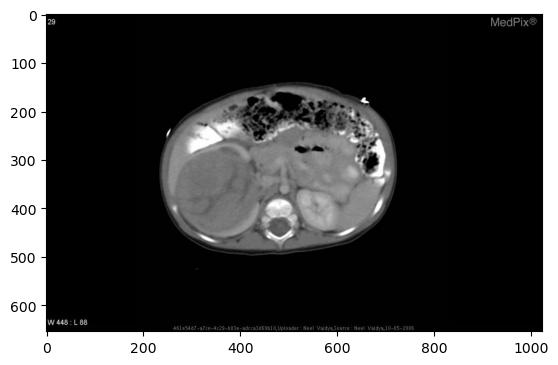

In [5]:
sample = dataset['train'][42]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [6]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

In [7]:
train_data = dataset['train']
val_data = dataset['validation']

In [8]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding


text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                    )

val_vqa_dataset = VQADataset(data=val_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor
                    )

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=True)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


In [10]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)


BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

num_epochs = 30
patience = 5
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
# scaler = torch.cuda.amp.GradScaler()


Question:  [CLS] what is the shape of the liver mass? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] infiltrative [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


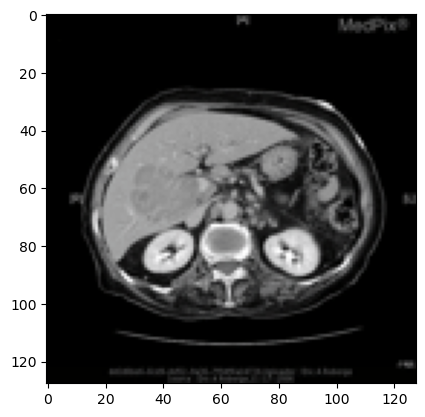

In [12]:
batch_idx = 0

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))


In [13]:


for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}")
    model.train()
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        
    print("Loss:", sum(total_loss))
    
    model.eval()
    eval_loss = 0
    total_accuracy = 0
    # for idx, batch in zip(tqdm(range(len(val_dataloader)), desc='Validating batch: ...'), val_dataloader):
    for batch in tqdm(val_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.item()

    tracking_information.append((sum(total_loss)/len(train_dataloader), eval_loss/len(val_dataloader), optimizer.param_groups[0]["lr"]))
    print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, sum(total_loss)/len(train_dataloader), eval_loss/len(val_dataloader), optimizer.param_groups[0]["lr"]))
    # scheduler.step()
    
    # if eval_loss < min_eval_loss:
    model.save_pretrained(f"Model/blip-{dataset_name}-model", from_pt=True)
    pickle.dump(tracking_information, open(f"Model/blip-{dataset_name}-model/tracking_information.pkl", "wb"))
    print(f"Saved model to Model/blip-{dataset_name}-model")
    #     min_eval_loss = eval_loss
    #     early_stopping_hook = 0
    # else:
    #     early_stopping_hook += 1
    #     if early_stopping_hook > patience:
    #         break


print("The finetuning process is complete!")


Epoch: 1


  0%|          | 0/29 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 223.75907278060913


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 - Training loss: 7.7158300958830734 - Eval Loss: 5.97983855009079 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 2


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 122.34387850761414


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2 - Training loss: 4.2187544312970395 - Eval Loss: 2.517459660768509 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 3


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 35.94698232412338


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3 - Training loss: 1.2395511146249443 - Eval Loss: 0.6235956624150276 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 4


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 9.340207010507584


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4 - Training loss: 0.3220761038106063 - Eval Loss: 0.41069261357188225 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 5


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 5.707946315407753


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5 - Training loss: 0.19682573501406045 - Eval Loss: 0.3731612414121628 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 6


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 4.42795916646719


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6 - Training loss: 0.15268824711955828 - Eval Loss: 0.3625158965587616 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 7


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 3.2305118199437857


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7 - Training loss: 0.1113969593084064 - Eval Loss: 0.353701813146472 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 8


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.5265570282936096


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8 - Training loss: 0.0871226561480555 - Eval Loss: 0.35351782850921154 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 9


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.1311886366456747


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9 - Training loss: 0.07348926333260947 - Eval Loss: 0.34551238641142845 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 10


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.8504967335611582


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 - Training loss: 0.06381023219176407 - Eval Loss: 0.34735799580812454 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 11


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.5597377000376582


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11 - Training loss: 0.053784058621988214 - Eval Loss: 0.35180755890905857 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 12


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.3867927640676498


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12 - Training loss: 0.047820440140263785 - Eval Loss: 0.3546033427119255 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 13


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.435751324519515


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13 - Training loss: 0.0495086663627419 - Eval Loss: 0.3515456411987543 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 14


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.1214231830090284


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14 - Training loss: 0.03866976493134581 - Eval Loss: 0.3570276275277138 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 15


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.1806231159716845


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15 - Training loss: 0.040711141930058085 - Eval Loss: 0.3544293940067291 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 16


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.8642796534113586


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16 - Training loss: 0.029802746669357193 - Eval Loss: 0.360613863915205 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 17


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.7554172305390239


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17 - Training loss: 0.02604887001858703 - Eval Loss: 0.3523071315139532 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 18


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.6591963334940374


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18 - Training loss: 0.02273090805151853 - Eval Loss: 0.35917832143604755 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 19


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.5915595097467303


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19 - Training loss: 0.02039860378437001 - Eval Loss: 0.35217650420963764 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 20


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.5157543569803238


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20 - Training loss: 0.01778463299932151 - Eval Loss: 0.3589510712772608 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 21


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.44665496284142137


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 21 - Training loss: 0.01540189527039384 - Eval Loss: 0.36983270198106766 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 22


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.45296780625358224


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 22 - Training loss: 0.015619579525985595 - Eval Loss: 0.3652784414589405 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 23


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.40338860964402556


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 23 - Training loss: 0.013909952056690537 - Eval Loss: 0.36290229484438896 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 24


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.43753671273589134


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 24 - Training loss: 0.01508747285296177 - Eval Loss: 0.42312853783369064 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 25


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.8021926805377007


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 25 - Training loss: 0.02766181657026554 - Eval Loss: 0.36260607093572617 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 26


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.4896623268723488


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 26 - Training loss: 0.016884907823184442 - Eval Loss: 0.3554604593664408 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 27


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.420247929636389


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 27 - Training loss: 0.014491307918496173 - Eval Loss: 0.3571905493736267 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 28


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.3322440795600414


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 28 - Training loss: 0.011456692398622119 - Eval Loss: 0.35734761133790016 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.26254626573063433


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 29 - Training loss: 0.009053319507952908 - Eval Loss: 0.3727535493671894 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
Epoch: 30


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.2254696988966316


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 30 - Training loss: 0.007774817203332124 - Eval Loss: 0.3751233462244272 - LR: 5e-05
Saved model to Model/blip-vqa-rad-model
The finetuning process is complete!


Question:  is there evidence of an aortic aneurysm?
Predicted Answer:  no
Actual Answer:  yes


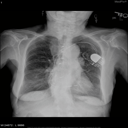

###################################################################
Question:  is there airspace consolidation on the left side?
Predicted Answer:  no
Actual Answer:  yes


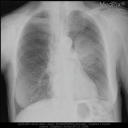

###################################################################
Question:  is there any intraparenchymal abnormalities in the lung fields?
Predicted Answer:  no
Actual Answer:  no


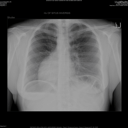

###################################################################
Question:  which side of the heart border is obscured?
Predicted Answer:  not sure
Actual Answer:  right


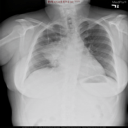

###################################################################
Question:  where are the kidney?
Predicted Answer:  not sure
Actual Answer:  not seen here


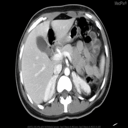

###################################################################
Question:  are the kidneys present in this image?
Predicted Answer:  not sure
Actual Answer:  no


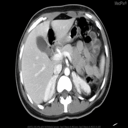

###################################################################
Question:  is the colon more prominent on the patient's right or left side?
Predicted Answer:  left side
Actual Answer:  left


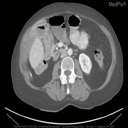

###################################################################
Question:  where is the colon most prominent from this view?
Predicted Answer:  to the right
Actual Answer:  left


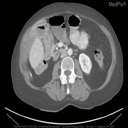

###################################################################
Question:  is the heart size in this image smaller or larger than if the image was taken ap?
Predicted Answer:  more than half the thorax
Actual Answer:  smaller


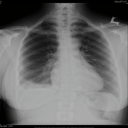

###################################################################
Question:  is the liver visible in the image?
Predicted Answer:  with contrast
Actual Answer:  no


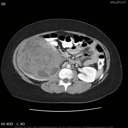

###################################################################
Question:  is this an axial image?
Predicted Answer:  not sure
Actual Answer:  yes


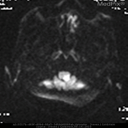

###################################################################
Question:  what structures are visible in this image?
Predicted Answer:  more than the intestines of the past manipulation??
Actual Answer:  skull cartilage and medulla


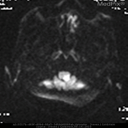

###################################################################
Question:  what is this lucency amid densities in the right lung?
Predicted Answer:  not sure
Actual Answer:  the right bronchus


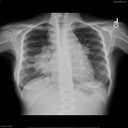

###################################################################
Question:  is there evidence of any abnormalities of the lung parenchyma?
Predicted Answer:  no
Actual Answer:  no


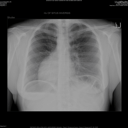

###################################################################
Question:  are the temporal bones fractured?
Predicted Answer:  not sure
Actual Answer:  no


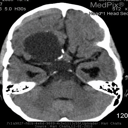

###################################################################
Question:  is there consolidation in the lungs?
Predicted Answer:  not sure
Actual Answer:  no


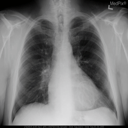

###################################################################
Question:  what type of image is this?
Predicted Answer:  not sure
Actual Answer:  plain film x - ray


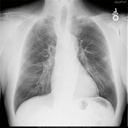

###################################################################
Question:  what are these opacities anterior to the right kidney?
Predicted Answer:  not sure
Actual Answer:  the small intestines


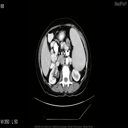

###################################################################
Question:  are the brain gyri atrophied?
Predicted Answer:  not sure
Actual Answer:  no


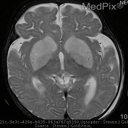

###################################################################
Question:  is the anatomy of the brain gyri affected?
Predicted Answer:  not sure
Actual Answer:  no


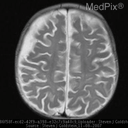

###################################################################
Question:  what is the medium density close to the anterior abdominal wall?
Predicted Answer:  the right costophrenic angle is blunted
Actual Answer:  the diaphragm


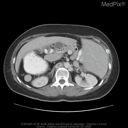

###################################################################
Question:  is this an ap image?
Predicted Answer:  not sure
Actual Answer:  no


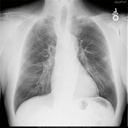

###################################################################
Question:  what is the plane of this image?
Predicted Answer:  with contrast
Actual Answer:  axial


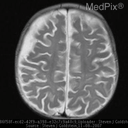

###################################################################
Question:  is this a ct image?
Predicted Answer:  not sure
Actual Answer:  no


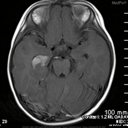

###################################################################
Question:  is there evidence of small bowel obstruction on this image?
Predicted Answer:  with contrast
Actual Answer:  yes


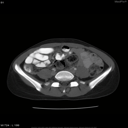

###################################################################
Question:  what type of image is this?
Predicted Answer:  dwi
Actual Answer:  ct with contrast


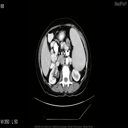

###################################################################
Question:  is there leakage of blood?
Predicted Answer:  no
Actual Answer:  no


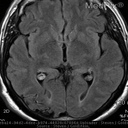

###################################################################
Question:  is there herniation?
Predicted Answer:  not sure
Actual Answer:  no


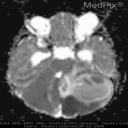

###################################################################
Question:  what bright white structures form an x?
Predicted Answer:  more than half the costophrenic angle, loss of the right hemidiaphragm
Actual Answer:  lateral ventricles


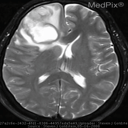

###################################################################
Question:  what are the bright white structures, almost forming an x "? "
Predicted Answer:  more than half the costophrenic angle of the right hemorrhage
Actual Answer:  lateral ventricles


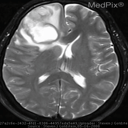

###################################################################
Question:  can you see the esophagus in this image?
Predicted Answer:  no
Actual Answer:  no


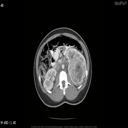

###################################################################
Question:  is the esophagus visible?
Predicted Answer:  not sure
Actual Answer:  no


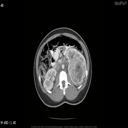

###################################################################
Question:  is this supratentorial or infratentorial?
Predicted Answer:  more than one
Actual Answer:  supratentorial


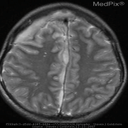

###################################################################
Question:  is this modality safe for pregnant women?
Predicted Answer:  no
Actual Answer:  no


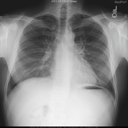

###################################################################
Question:  can fluids be highlighted with this modality?
Predicted Answer:  no
Actual Answer:  yes


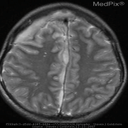

###################################################################
Question:  is there small bowel thickening present?
Predicted Answer:  not sure
Actual Answer:  yes


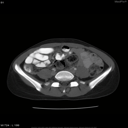

###################################################################
Question:  are the kidneys normal?
Predicted Answer:  not sure
Actual Answer:  yes


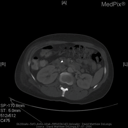

###################################################################
Question:  do the kidneys appear to be normal?
Predicted Answer:  not sure
Actual Answer:  yes


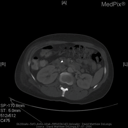

###################################################################
Question:  are the lateral ventricles visible?
Predicted Answer:  not sure
Actual Answer:  yes


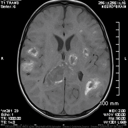

###################################################################
Question:  can the lateral ventricles be seen?
Predicted Answer:  not sure
Actual Answer:  yes


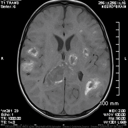

###################################################################
Question:  what hypoattenuated tissue is between the abdominal wall and skin?
Predicted Answer:  thermosclerotic fluid of the left lateral ventricles
Actual Answer:  fat


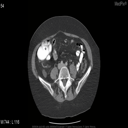

###################################################################
Question:  what is the dark structure underneath the skin?
Predicted Answer:  not sure
Actual Answer:  fat


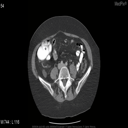

###################################################################
Question:  does this mass likely represent a neoplastic process?
Predicted Answer:  no
Actual Answer:  no


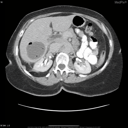

###################################################################
Question:  is this a neoplastic process?
Predicted Answer:  not sure
Actual Answer:  no


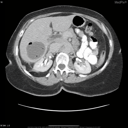

###################################################################
Question:  is the vertebrae fractured?
Predicted Answer:  not sure
Actual Answer:  no


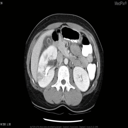

###################################################################
Question:  is there a verterbral fracture?
Predicted Answer:  no
Actual Answer:  no


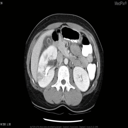

###################################################################
Question:  was the patient positioned appropriately without tilting?
Predicted Answer:  no
Actual Answer:  yes


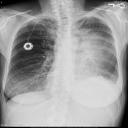

###################################################################
Question:  can you evaluate a mediastinum in the shown image?
Predicted Answer:  no
Actual Answer:  no


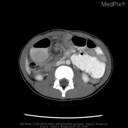

###################################################################
Question:  is the mediastinum visualized?
Predicted Answer:  not sure
Actual Answer:  no


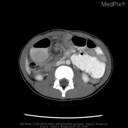

###################################################################
Question:  where is the tip of the line?
Predicted Answer:  not sure
Actual Answer:  mid left subclavian vein


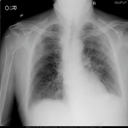

###################################################################
Question:  where is the tip of the port - a - cath catheter located?
Predicted Answer:  not sure
Actual Answer:  mid left subclavian vein


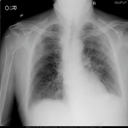

###################################################################
Question:  do you see hylar lymphadenopathy in this image?
Predicted Answer:  no
Actual Answer:  yes


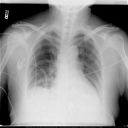

###################################################################
Question:  is there hylar lymphadenopathy?
Predicted Answer:  no
Actual Answer:  yes


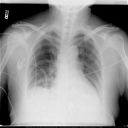

###################################################################
Question:  is there a widened mediastinum?
Predicted Answer:  no
Actual Answer:  yes


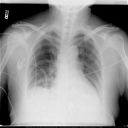

###################################################################
Question:  is the mediastinum wider than normal?
Predicted Answer:  not sure
Actual Answer:  yes


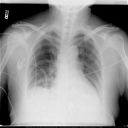

###################################################################
Question:  is the heart enlarged?
Predicted Answer:  not sure
Actual Answer:  yes


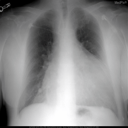

###################################################################
Question:  is there cardiomegaly?
Predicted Answer:  not sure
Actual Answer:  yes


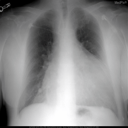

###################################################################
Question:  is the small bowel appropriately identified with gi contrast?
Predicted Answer:  with contrast
Actual Answer:  yes


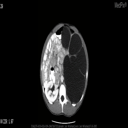

###################################################################
Question:  is there fluid in the lung?
Predicted Answer:  not sure
Actual Answer:  yes


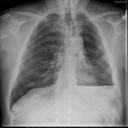

###################################################################
Question:  is this a pleural effusion
Predicted Answer:  not sure
Actual Answer:  yes


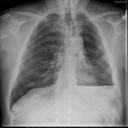

###################################################################
Question:  is mass effect present?
Predicted Answer:  not sure
Actual Answer:  no


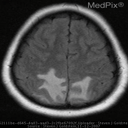

###################################################################
Question:  is there mass effect?
Predicted Answer:  not sure
Actual Answer:  no


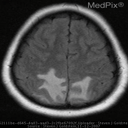

###################################################################
Question:  how was this image taken
Predicted Answer:  with contrast
Actual Answer:  t2 - mri


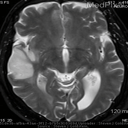

###################################################################
Question:  is there a mass
Predicted Answer:  not sure
Actual Answer:  yes


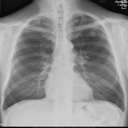

###################################################################
Question:  is a mass present in this xray?
Predicted Answer:  no
Actual Answer:  yes


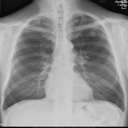

###################################################################
Question:  describe the pathology
Predicted Answer:  not sure
Actual Answer:  cardiomegaly with pulmonary edema


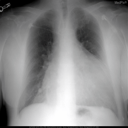

###################################################################
Question:  what is the pathology?
Predicted Answer:  not sure
Actual Answer:  cardiomegaly with pulmonary edema


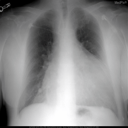

###################################################################
Question:  what organ system is the pathology?
Predicted Answer:  emphysema
Actual Answer:  pulmonary / lymphatic


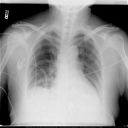

###################################################################
Question:  is there a small bowel obstruction?
Predicted Answer:  with and iv contrast
Actual Answer:  yes


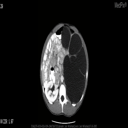

###################################################################
Question:  is there brain edema
Predicted Answer:  not sure
Actual Answer:  yes


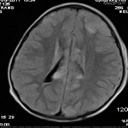

###################################################################
Question:  is the brain swollen?
Predicted Answer:  not sure
Actual Answer:  yes


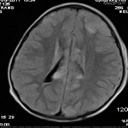

###################################################################
Question:  what is the location of the cavitary lesion
Predicted Answer:  not sure
Actual Answer:  right upper lobe


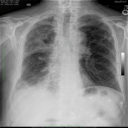

###################################################################
Question:  where is the cavitary lesion located?
Predicted Answer:  not sure
Actual Answer:  right upper lobe


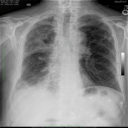

###################################################################
Question:  are there increased vascular markings
Predicted Answer:  not sure
Actual Answer:  yes


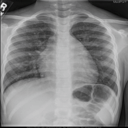

###################################################################
Question:  are the vascular markings increased?
Predicted Answer:  not sure
Actual Answer:  yes


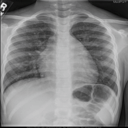

###################################################################
Question:  what plane is this film
Predicted Answer:  not sure
Actual Answer:  coronal


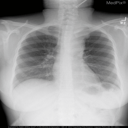

###################################################################
Question:  what is the location of the mass?
Predicted Answer:  not sure
Actual Answer:  head of the pancreas


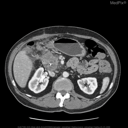

###################################################################
Question:  where is the mass located?
Predicted Answer:  not sure
Actual Answer:  head of the pancreas


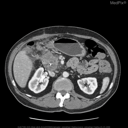

###################################################################
Question:  the mass is found in which part of the pancreas?
Predicted Answer:  the left kidney is more in line with the trachea than the left
Actual Answer:  the pancreatic head


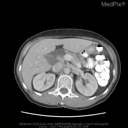

###################################################################
Question:  are there hyper attenuating material along the aortic walls?
Predicted Answer:  no
Actual Answer:  yes


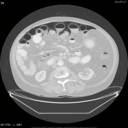

###################################################################
Question:  what type of mri sequence is displayed in this image?
Predicted Answer:  dwi
Actual Answer:  t2 weighted mri


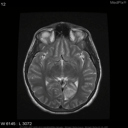

###################################################################
Question:  from what structure is the large hypodense mass emanating from?
Predicted Answer:  more than one
Actual Answer:  the base of the cecum


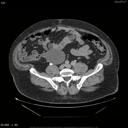

###################################################################
Question:  what lobe of the brain is the lesion located in?
Predicted Answer:  the right mainstem bronchus is more in line with the trachea than the
Actual Answer:  right frontal lobe


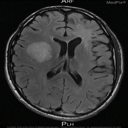

###################################################################
Question:  is this an mri?
Predicted Answer:  not sure
Actual Answer:  no


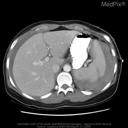

###################################################################
Question:  does this patient have a pneumothorax?
Predicted Answer:  not sure
Actual Answer:  no


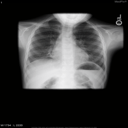

###################################################################
Question:  in what plane was this image taken?
Predicted Answer:  with contrast
Actual Answer:  axial plane


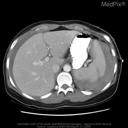

###################################################################
Question:  is this an mri or a ct scan?
Predicted Answer:  ct
Actual Answer:  mri


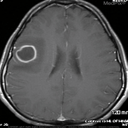

###################################################################
Question:  can the optic nerve be visualized in this mri image?
Predicted Answer:  no
Actual Answer:  yes


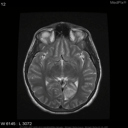

###################################################################
Question:  in which two ventricles can calcifications be seen on this ct scan?
Predicted Answer:  the aorta is more than half the diameter of the aorta
Actual Answer:  the 3rd ventricle and the lateral ventricles


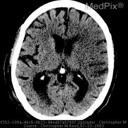

###################################################################
Question:  what part of the body is being imaged here?
Predicted Answer:  thermosclerotic fluid of the left heart, cardiom, with contrast
Actual Answer:  abdomen


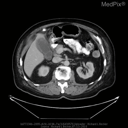

###################################################################
Question:  are there calcifications present on the abdominal aorta?
Predicted Answer:  no
Actual Answer:  yes


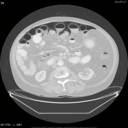

###################################################################
Question:  does this patient have pneumomediastinum?
Predicted Answer:  no
Actual Answer:  no


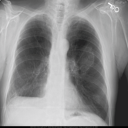

###################################################################
Question:  what abnormality is seen on the left side of the frontal lobe?
Predicted Answer:  more acute means more inflammation - leading to enhancement?
Actual Answer:  regression of left frontal mass


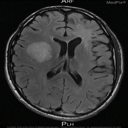

###################################################################
Question:  is this a coronal view?
Predicted Answer:  not sure
Actual Answer:  no


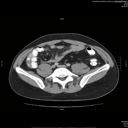

###################################################################
Question:  are these normal kidney findings?
Predicted Answer:  not sure
Actual Answer:  no


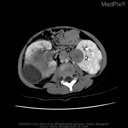

###################################################################
Question:  diaphragm is elevated on which side?
Predicted Answer:  right
Actual Answer:  right


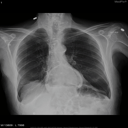

###################################################################
Question:  which side of the diaphragm is elevated?
Predicted Answer:  left
Actual Answer:  right


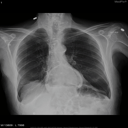

###################################################################
Question:  where does the l renal vein connect to
Predicted Answer:  to the right of the trachea
Actual Answer:  ivc


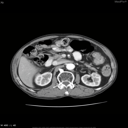

###################################################################
Question:  where does the l renal vein drain into?
Predicted Answer:  to the right of the trachea, memory?
Actual Answer:  ivc


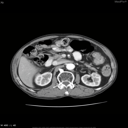

###################################################################
Question:  does the lesion appear to be wedge - shaped?
Predicted Answer:  no
Actual Answer:  yes


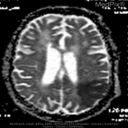

###################################################################


In [17]:
# add batch dimension + move to GPU|
model.eval()
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

In [21]:
torch.cuda.empty_cache()

In [20]:
# add batch dimension + move to GPU|
model.eval()

answers = []
predicted_answers = []

for x in tqdm(range(len(val_vqa_dataset))):
    sample = val_vqa_dataset[x]
    # print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    predicted_answers.append(text_processor.decode(outputs[0],skip_special_tokens=True))
    answers.append(text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    

  0%|          | 0/451 [00:00<?, ?it/s]

In [22]:
len(answers), len(predicted_answers)

(451, 451)

In [55]:
from difflib import SequenceMatcher

hypotheses = []
references = []

ratios = []

# correct 
tp = 0
tn = 0
fp = 0
fn = 0

for a, pa in zip(answers, predicted_answers):
    if a in ['yes','no']:
        if pa.startswith(a):
            if a == 'yes':
                tp += 1
            elif pa == 'no' or pa.startswith('no ') or pa.startswith('non'):
                tn += 1
        else:
            if a == 'yes':
                fn += 1
            else:
                fp += 1
    else:
        # hypotheses.append(pa)
        # references.append(a)
        ratios.append(SequenceMatcher(a=a, b=pa).ratio())

accuracy = (tp+tn)/(len(answers)-len(ratios))
ratio = sum(ratios)/len(ratios)
f"exact_match: {accuracy}", f"similarity: {ratio}", tp, tn, fp, fn

('exact_match: 0.18725099601593626',
 'similarity: 0.24900457451671784',
 0,
 47,
 6,
 118)

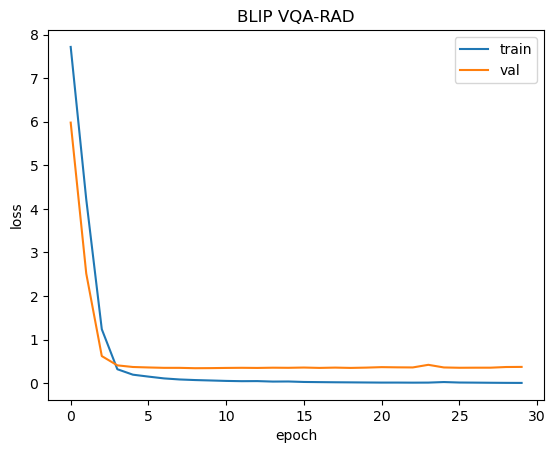

In [38]:
import numpy as np

arr = np.array(tracking_information)

plt.figure(1)
plt.clf()
plt.plot(arr[:,0], label='train')
plt.plot(arr[:,1], label='val')
plt.title('BLIP VQA-RAD')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
_=plt.show()

In [44]:
import json
with open(f"Model/blip-{dataset_name}-model/answers.json", "w") as wf:
    json.dump(answers, wf)
with open(f"Model/blip-{dataset_name}-model/predicted_answers.json", "w") as wf:
    json.dump(predicted_answers, wf)   